<a href="https://colab.research.google.com/github/UBela/BV-ML-CV-Praktikum/blob/main/license_plate_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import cv2
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision
import xml.etree.ElementTree as xet
from glob import glob



In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:

#create the dataset containing the images and annotations containing the bounding boxes
class Licenseplates(Dataset):

    def __init__(self, image_dir, annotation_dir):
        self.image_dir = image_dir
        self.annotation_dir = annotation_dir
        self.data = self._parse_xml_files()
       
  
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.data[idx]['filename'])
        image = Image.open(image_path).convert("RGB")

        annotations = self.data[idx]

        # Return image and annotations as tensors
        return image, annotations

    def _parse_xml_files(self):
        # Parse XML files and extract relevant information
        data = []
        xml_files = [file for file in os.listdir(self.annotation_dir) if file.endswith('.xml')]
        for xml_file in xml_files:
            label_dict = {}
           
            # Use an XML parser to extract relevant information from the XML file
            # and create a dictionary containing image filename, bounding box coordinates, and image dimensions
            # Append the dictionary to the data list
            xml_path = os.path.join(self.annotation_dir, xml_file)
            info = xet.parse(xml_path)
            root = info.getroot()
            image_filename = root.find('filename').text
            image_width = int(root.find('size/width').text)
            image_height = int(root.find('size/height').text)

            annotations = []
            for obj in root.findall('object'):
                label = obj.find('name').text
                xmin = int(obj.find('bndbox/xmin').text)
                ymin = int(obj.find('bndbox/ymin').text)
                xmax = int(obj.find('bndbox/xmax').text)
                ymax = int(obj.find('bndbox/ymax').text)
                bb = [xmin, ymin, xmax, ymax]
            data.append({
                'filename': image_filename,
                'width': image_width,
                'height': image_height,
                'class': 0,
                'bounding_box': bb
                 })

        return data


{'filename': 'Cars395.png', 'width': 400, 'height': 301, 'class': 0, 'bounding_box': [241, 182, 288, 205]}


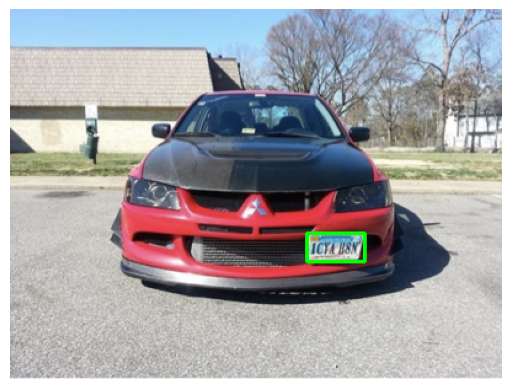

In [5]:
path_images = './drive/MyDrive/license_plate_recognition/images/'
path_annotations = './drive/MyDrive/license_plate_recognition/annotations/'

#create dataset
dataset = Licenseplates(path_images, path_annotations)

#example of image and bounding box
image, ann = dataset[-1]
bb = ann['bounding_box']
print(ann)
image_array = np.array(image)
cv2.rectangle(image_array, (bb[0], bb[1]), (bb[2], bb[3]), (0, 255, 0), 2)
image_with_rectangle = Image.fromarray(image_array)
plt.imshow(image_with_rectangle)
plt.axis('off')
plt.show()

In [6]:

#Pre-Processing the images:
images = []
annotations = []

# Split dataset into images and annotations
for image, annotation in dataset:
    images.append(image)
    annotations.append(annotation)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((416, 416)),  
])

In [17]:
def preprocess_images(images, transform):

  transformed_images = [transform(image) for image in images]
  transformed_images = torch.stack(transformed_images) 

  #normalize the images    
  transformed_images = transformed_images.float() / 255.
  mu, std = transformed_images.mean(dim=(0,2,3)), transformed_images.std((0,2,3))

  normalize = transforms.Normalize(mean=mu, std=std)
  transformed_images = [normalize(image) for image in transformed_images]
  return torch.stack(transformed_images)


processed_images = preprocess_images(images, transform)




/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [54]:
#pre process bounding box annotations for YOLO format
def preprocess_annotations(annotations):
    transformed_annotations = []
    for annotation in annotations:
        # Perform preprocessing operations on the annotation
        id = 0
        xmin, ymin, xmax, ymax = annotation['bounding_box']
        w = annotation['width']
        h =  annotation['height']
        x_center = (xmin + xmax) / (2.0 * w)
        y_center = (ymin + ymax) / (2.0 * h)
        bbox_width = (xmax - xmin) / w
        bbox_height = (ymax - ymin) / h
        transformed_annotations.append([x_center, y_center, bbox_width, bbox_height,int(id)])

        
    return torch.tensor(transformed_annotations)

print(annotations[0]['bounding_box'])
processed_annotations = preprocess_annotations(annotations)
processed_annotations[0][1:]

[226, 125, 419, 173]


tensor([0.5560, 0.3860, 0.1791, 0.0000])

(416, 416, 3)


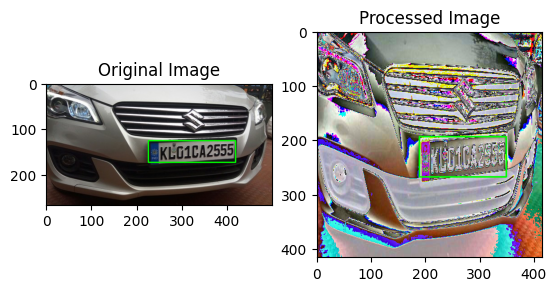

Original Annotation:
[226, 125, 419, 173]
Processed Annotation:
tensor([0.5560, 0.3860, 0.1791, 0.0000])


In [55]:
# Check processed images
# Display original and processed images side by side
fig, axes = plt.subplots(1, 2)

# Original image
original_image = np.array(images[0])
og_annotation = annotations[0]  # Select an original annotation
bb = og_annotation['bounding_box']
cv2.rectangle(original_image, (bb[0], bb[1]), (bb[2], bb[3]), (0, 255, 0), 2)
axes[0].imshow(original_image)
axes[0].set_title("Original Image")

# Processed image
processed_image = processed_images[0]
processed_image_pil = transforms.ToPILImage()(processed_image)
processed_image = np.array(processed_image_pil)
print(processed_image.shape)  # Select the corresponding processed image
processed_annotation = processed_annotations[0]
xc, yc, w, h = processed_annotation[:-1]
xmin = int((xc - w / 2.0) * processed_image.shape[1])
ymin = int((yc - h / 2.0) * processed_image.shape[0])
xmax = int(xmin + w * processed_image.shape[1])
ymax = int(ymin + h * processed_image.shape[0])
cv2.rectangle(processed_image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
axes[1].imshow(processed_image)
axes[1].set_title("Processed Image")

plt.show()

# Processed annotation
print("Original Annotation:")
print(og_annotation['bounding_box'])

print("Processed Annotation:")
print(processed_annotation[1:])

In [46]:
print(processed_images.shape)
print(processed_annotations.shape)

torch.Size([433, 3, 416, 416])
torch.Size([433, 5])


In [80]:
#split into train and test set
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [ ]:




dl_train = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
# get pretrained yolo model:
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

/usr/local/lib/python3.9/dist-packages/torch/hub.py:286: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
requirements: Ultralytics requirement "gitpython>=3.1.30" not found, attempting AutoUpdate...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 k